In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
np.set_printoptions(suppress=True)

In [3]:
# Helper function for visualization
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [16]:
# Load the data and process it.

df = pd.read_csv("mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

df = df[df['period'] < 35]

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
data = data.groupby(['min', 'max', 'count']).size().reset_index(name='count_history')

Text(0,0.5,'Distinct Workers')

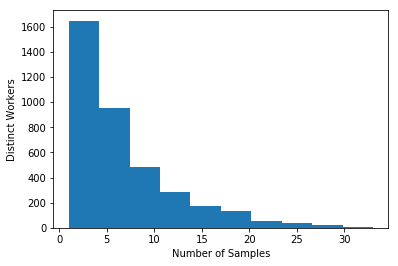

In [17]:
plt.hist(data['count'].values);
plt.xlabel('Number of Samples')
plt.ylabel('Distinct Workers')

In [20]:
# Summary of input

S = df['period'].max() + 1
V = len(workers)
freqs = data['count_history'].values
H = len(freqs)

print('Sampling periods:', S)
print('Unique patterns:', H)
print('Unique workers:', V)

Sampling periods: 35
Unique patterns: 3802
Unique workers: 46114


In [31]:
# We want to see the survival marks to compute the total survival
# e.g, Arrive: 1, Depart: 2 => 011
# Dims: SxSxS
def make_survival(S):
    mask = np.zeros([S,S,S])  # arrival, departure, presence_sequence
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            mask[s,q]= np.concatenate((c1, c2, c3))
    return mask
survival = tt.constant(make_survival(S))

In [32]:
# A more compact way to represent all Arrival and departures from the data
# This is part of the input data, so we preprocess it!
def get_hmask(S, H, data):
    h_mask = np.zeros((H,S,S))
    for wh in np.arange(H):
        f, l = data['min'].values[wh] , data['max'].values[wh]
        h_mask[wh, :f+1, l:] = 1
    return h_mask
hmask = tt.constant(get_hmask(S, H, data))
hmask.shape

Shape.0

In [33]:
# For a given outcome in {1,S} (Frequency of capture that's not 0) 
# Generate the Binomial parameters n and i   choose(n, i)
# Nn is the duration from arrival to departure
# Ni is the Frequency we are intersted in
# Dim: SxSxS
def make_binmask(S, data):
    i = data['count'].values
    i = i[:, np.newaxis, np.newaxis] *  np.ones((H, S, S))
    n = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (H, S, S))
    return tt.constant(i), tt.constant(n)
Ni, Nn = make_binmask(S, data)
print('Tensor with number of captures', Ni.shape)
print('Tensor with durations from first to last seen', Nn.shape)

Tensor with number of captures Shape.0
Tensor with durations from first to last seen Shape.0


In [34]:
# Helper functions for the Beta Bernoulli Process
# TODO: switch to a single function even for the special case of 0 captures.

def get_BetaBi(a,b, S, Ni, Nn):
    # The beta binomial
    BBi  =  bound(betaln(Ni + a +1, Nn - Ni + b) - betaln(a +1, b),
                     Ni >= 0, Ni <= Nn,
                     a > 0, b > 0)
    # The above is the computation of the log, so we take the exponent
    return tt.exp(BBi)

def get_BetaB0(a, b, S):
    # The beta binomial for 0 captures
    Nn = tt.triu(tt.ones([S,S]), 0).cumsum(axis =1).eval()
    #B0 = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    B0 = bound(betaln(a+1, Nn + b) - betaln(a+1, b), 
               a > 0, b > 0)
    return tt.exp(B0)

In [35]:
def logp_capture(arrival_probs, departure_probs, a, b, U, survival_mask, Ni, Nn, S, V):
    def ll_capture_f(Nh, data_first_last_mask):
          
        # Likelihood of observing Li captures
        
        # compute the survival
        survival_prob = tt.pow(1 - departure_probs, survival_mask)
        survival_prob = tt.prod(survival_prob, axis=2)
        # compute the arrival and departure
        LAD      = arrival_probs[:, np.newaxis] * survival_prob * departure_probs    # SxS
        # keep only true possibilites
        True_LAD = LAD * data_first_last_mask # SxSxS
        
        # sum along the freqencies of catpures
        BetaBi  = get_BetaBi(a, b, S, Ni, Nn)
        Li      = tt.batched_tensordot(True_LAD, BetaBi, axes = 2) # S
        
        # Likelihood of No-Capture L0
        
        True_LAD0    = LAD * tt.triu(tt.ones((S,S)), 0)
        BetaB0   = get_BetaB0(a, b, S)
        L0       = tt.sum(True_LAD0 * BetaB0)
        
        # Multinomial
        obj1 = tt.gammaln(V + U + 1) - tt.gammaln(U + 1) - tt.sum(tt.gammaln(Nh+1))
        obj2 = tt.sum(Nh * tt.log(Li))
        obj3 = U * tt.log(L0)
        
        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [37]:
# custom log-liklihood
# model
with pm.Model() as model:
    # parameters
    U = pm.Uniform('Unseen', lower=30000, upper=300000)
    a = pm.Uniform('alpha', .000001, 10)
    b = pm.Uniform('beta', 0.1, 20)
    
    phi = tt.zeros(S)
    phi_v    = pm.Uniform('departure', 0.01, .1, shape=S-1)
    phi = tt.set_subtensor(phi[S-1], 1.)
    phi = tt.set_subtensor(phi[:S-1],phi_v)
    
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    #U_print = tt.printing.Print('Unseen')(U)
    #a_print = tt.printing.Print('alpha')(a)
    #b_print = tt.printing.Print('beta')(b)
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U, survival, Ni, Nn, S, V), 
                        observed={'Nh': freqs ,
                                  'data_first_last_mask': hmask })

# ADVI Sampling

In [38]:
# "Super fast Sampling" using ADVI
with model:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=2000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=1000)
    trace_vi = approx.sample(5000) 
    
    elbos1 = -inference.hist

Average Loss = 2.1266e+05: 100%|██████████| 2000/2000 [16:57<00:00,  1.97it/s]
Finished [100%]: Average Loss = 2.1227e+05
Average Loss = 1.5221e+05: 100%|██████████| 1000/1000 [08:31<00:00,  1.95it/s]
Finished [100%]: Average Loss = 1.5224e+05


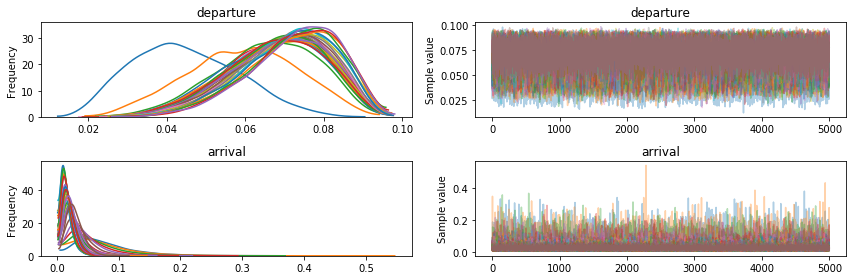

In [81]:
pm.traceplot(trace_vi, varnames=['departure', 'arrival']);

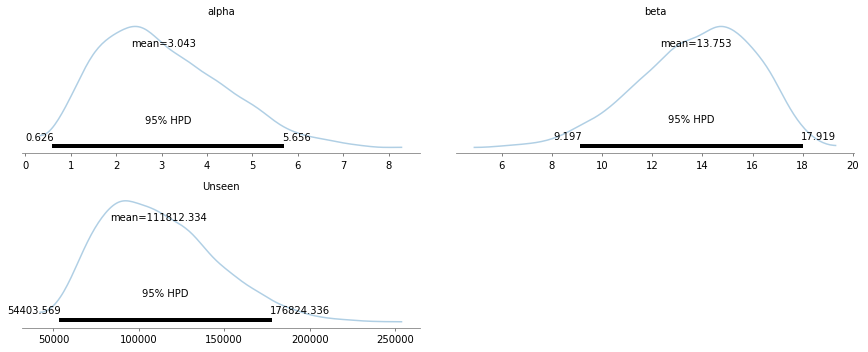

In [39]:
pm.plot_posterior(trace_vi, kde_plot = True, varnames = ['alpha', 'beta', 'Unseen']);

In [40]:
pm.summary(trace_vi, ['arrival'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
arrival__0,0.059335,0.030062,0.000393,0.013137,0.116390
arrival__1,0.035959,0.018269,0.000257,0.007795,0.071300
arrival__2,0.024588,0.013839,0.000177,0.004988,0.051761
arrival__3,0.020445,0.011743,0.000183,0.004150,0.044400
arrival__4,0.019638,0.010821,0.000153,0.003823,0.040658
arrival__5,0.018319,0.010604,0.000164,0.003903,0.039099
arrival__6,0.017938,0.010315,0.000130,0.003687,0.039056
arrival__7,0.017489,0.009921,0.000138,0.003530,0.036380
arrival__8,0.017336,0.009687,0.000131,0.003792,0.037220
arrival__9,0.017456,0.009674,0.000144,0.003976,0.036709


Text(0,0.5,'Arrival Percentage')

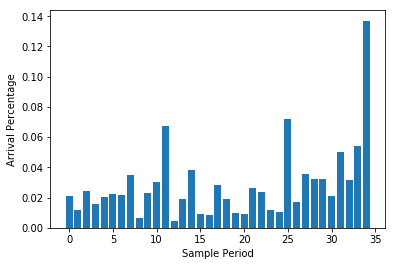

In [41]:
# Percentage of Super-population Arrivals
plt.bar(np.arange(S), trace_vi['arrival'][-1])
plt.xlabel('Sample Period')
plt.ylabel('Arrival Percentage')

Text(0,0.5,'Departure Probability')

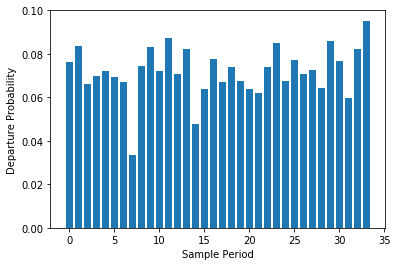

In [42]:
# Percentage of Departures
plt.bar(np.arange(S-1), trace_vi['departure'][-1])
plt.xlabel('Sample Period')
plt.ylabel('Departure Probability')

# MCMC based Sampling

In [50]:
# Now we use precise sampling methods .. that take ages
with model:
  posterior = pm.sample(500,  chains = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [arrival, departure, beta, alpha, Unseen]
 29%|██▊       | 287/1000 [8:33:40<21:16:07, 107.39s/it]/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks


/usr/local/lib/python3.7/site-packages/pymc3/plots/energyplot.py:54: RuntimeWarning: Mean of empty slice.
  series = [('Marginal energy distribution', energy - energy.mean()),


ValueError: zero-size array to reduction operation minimum which has no identity

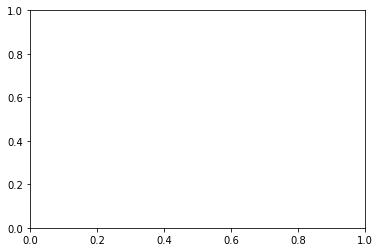

In [52]:
pm.energyplot(posterior);

In [53]:
plot_traces(posterior, varnames = ['Unseen', 'alpha', 'beta']);

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

ValueError: Too few elements for interval calculation

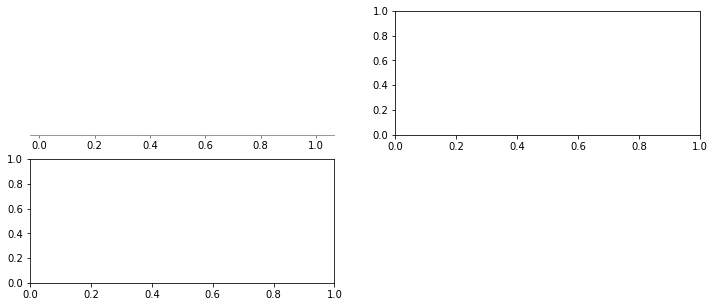

In [54]:
pm.plot_posterior(posterior, varnames = ['Unseen', 'alpha', 'beta']);

In [55]:
pm.summary(posterior, ['arrival'])

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

<BarContainer object of 36 artists>

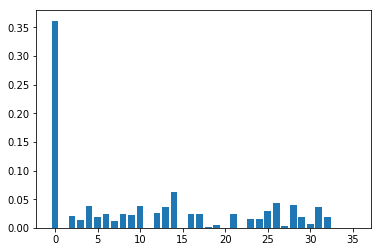

In [115]:
# Percentage of Super-population Arrivals
plt.bar(np.arange(S), posterior['arrival'][-1])

<BarContainer object of 35 artists>

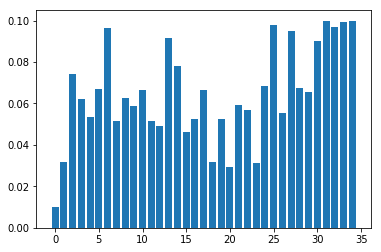

In [116]:
# Percentage of Departures
plt.bar(np.arange(S-1), posterior['departure'][-1])

In [78]:
46145 + 180000

226145